### Variational Inference with Normalizing Flows

#### background
1. The idea is to approximate a complex multimodal probability density with a simple probability density followed by a sequence of invertible nonlinear transforms. 
2. Inference in such model requires a computation of multiple Jacobian determinants, that can be computationaly expensive. 
3. Authors propose a specific form of the transformation that reduces the cost of computing the Jacobians.

#### NOTE: 
1. currently we provide implementation for the simple case, where the true density can be expressed in a closed form, so it's possible to explicitly minimize KL-divergence between the true density and the density represented by a normalizing flow. 
2. Implementing the most general case of normalizing which is capable of learning from the raw data is a bit problematic for the transformation described in the paper since inverse function for such transformation can not be expressed in a closed form.

#### Steps to follow after pytorch:
1. need to install other dependencies from requirements.txt. If you are using pip, simply run pip install -r requirements.txt.
2. After you have installed the dependencies, run python run_experiment.py and collect the results in the experiments folder.

A very useful website to introduce Pytorch code:
1. https://hsaghir.github.io/data_science/pytorch_starter/
2. https://stackoverflow.com/questions/48796169/how-to-fix-ipykernel-launcher-py-error-unrecognized-arguments-in-jupyter
3. https://towardsdatascience.com/a-look-at-gradient-descent-and-rmsprop-optimizers-f77d483ef08b

In [2]:
!pip install pyro-ppl

     |████████████████████████████████| 276kB 2.8MB/s 
     |████████████████████████████████| 748.9MB 14kB/s 
     |████████████████████████████████| 51kB 19.6MB/s 
  Created wheel for pyro-ppl: filename=pyro_ppl-0.4.1-cp36-none-any.whl size=371731 sha256=8c27ff09e938d327c9be2584166eec4c8897d113283f40cfa08b54a9336ec7e2
  Stored in directory: /root/.cache/pip/wheels/fb/47/97/848e699fb40fc9fd17f421c135cf7bc121dcf3f0c8519e89b2
Successfully built pyro-ppl
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [7]:
!pip install mag

In [0]:
# !python -m pip install --upgrade pip
# install git to avoid git++ error
# !pip install git+https://github.com/ex4sperans/mag
# from mag.experiment import Experiment

# to avoid possible crash from argparse package
# use easydict to replace
# !pip install easydict

import os
import torch
import pyro
import numpy as np
import argparse
import easydict

from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.autograd import Variable
# from mag.experiment import Experiment
from matplotlib import pyplot as plt

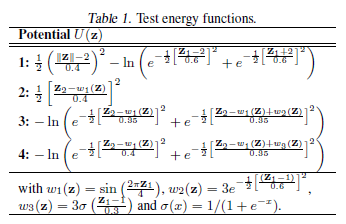

In [0]:
# To provide an insight into the representative power of density approximations based on normalizing flows
# we parameterize a set of unnormalized 2D densities p(z)~ exp[-U(z)] which are listed below.
from IPython.display import Image
Image(filename='table1.PNG', width=400)

In [0]:
# density function
def p_z(z):
    # torch.chunk(tensor, chunks, dim=0) -> tensor into num chunks
    # divide the tensor into two parts/columns
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1**2+z2**2)
    exp1 = torch.exp(-0.5*((z1-2)/0.8)**2)
    exp2 = torch.exp(-0.5*((z1+2)/0.8)**2)
    # potential U(z) for the first function
    u = 0.5*((norm-4)/0.4)**2-torch.log(exp1+exp2)
    return torch.exp(-u)

In [0]:
# tools
# in order to avoid log(0) thus add a small number
def safe_log(z):
    return torch.log(z + 1e-7)
# generate random normal samples-function
def random_normal_samples(n, dim=2):
    return torch.zeros(n, dim).normal_(mean=0, std=1)

#### Flows:

In [0]:
# we can define custom layers by sub-classing torch.nn.Module and implement a forward() function
# that accepts a Variable() as input and produce a Variable() as output. 
# We can even make a dynamic network by defining a layer that morphs in time!

# When defining a custom layer, 2 functions need to be implemented:
# __init__ function has to always be inherited first then define parameters of the layers here as the class variables self.x

# forward function is where we pass an input through the layer, perform operations on inputs
# using parameters and return the output. The inputs needs to be autograd.Variable() so that
# pytorch can build the computational graph of the layer

In [0]:
class PlanarFlow(nn.Module):
    
    # parameter: the dimension of the input/output variable
    # a planar normalizing flow that uses the transformation y=z+u*tanh(w^Tz+b)
    # wherer z are the inputs, y are the outputs and learnable parameters are b, u(R^D), w(R^D) for input dimension D
    # for this to be an invertible transformation, the condition w^T*z>-1 is needed
    def __init__(self, dim):
        super().__init__()
        # parameter w
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        # parameter b
        self.bias = nn.Parameter(torch.Tensor(1))
        # parameter u
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        # a smooth element-wise non-linearity function
        self.tanh = nn.Tanh()
        self.reset_parameters()

    # transformation of parameters
    # distributions of parameters are uniform dis
    def reset_parameters(self):
        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)
    
    # linear transformation functions
    def forward(self, z):
        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)

In [0]:
# one of the many activation functions is the hyperbolic tangent function (tanh)
# tanh(x) = (e^z-e^(-z))/(e^z+e^(-z)) and its outpus is in (-1,1)
# its derivative comes out to be 1-tanh^2(x)

# A helper class to compute the determinant of the gradient of the planar flow transformation.
class PlanarFlowLogDetJacobian(nn.Module):
    
    # parameter is another flow that needs to calculate Log Det Jacobian
    def __init__(self, affine):
        super().__init__()
        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh
    
    def forward(self, z):
        activation = F.linear(z, self.weight, self.bias)
        # calculate the derivate of self.tanh(activation) w.r.t the variable z
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        # matrix multiplication in PyTorch
        # calculate the derivative based on formula-12 
        # in "variational inference with normalizing flows"
        det_grad = 1 + torch.mm(psi, self.scale.t())
        # calculate Log Det Jacobian
        return safe_log(det_grad.abs())

In [0]:
# Use the nn package to define our model as a sequence of layers for the normalizing flow
class NormalizingFlow(nn.Module):
    
    # parameters contain the dimension of input
    # and length of the sequence of transformation
    def __init__(self, dim, flow_length):
        super().__init__()
        # nn.Sequential is a Module which contains other Modules
        # and applies them in sequence to produce its output. 
        # Each Linear Module computes output from input using a linear function
        # and holds internal Tensors for its weight and bias.
        
        # the following two sequential commands help create a sequence of modules for 
        # transformations and corresponding log jacobians to use further
        self.transforms = nn.Sequential(*(PlanarFlow(dim) for _ in range(flow_length)))
        self.log_jacobians = nn.Sequential(*(PlanarFlowLogDetJacobian(t) for t in self.transforms))

    # use combination mappings of transforms and Log jacobian module to calculate 
    # the log jacobian at each step and final Zk output
    # z is the input Z0
    def forward(self, z):
        log_jacobians = []
        for transform, log_jacobian in zip(self.transforms, self.log_jacobians):
            # extract the Log jacobian of z and put it into jacobians list
            log_jacobians.append(log_jacobian(z))
            # transform further one step each time
            z = transform(z)
        zk = z
        # Zk is the final output after k times linear transformations
        # return both final output state and jacobian list for Z1,Z2,...Zk
        return zk, log_jacobians

#### Losses:

In [0]:
# introduce the marginal likelihood of a probabilistic model
# need to optimize a lower bound on the marginal likelihood
# this bound is often referred to as the negative free energy F or as the evidence lower bound(ELBO)
# log(p(theta)x) >= -F(x) -- from "Variational Inferencee with normalizing flows (3)"
# Flo-based free energy bound
class FreeEnergyBound(nn.Module):    
    def __init__(self, density):
        super().__init__()
        self.density = density
    # from "Variational Inference with normalizing flows (15)"
    # take the negative expectation of E(log(p(x,Zk))) and E(sum of Log Jacobian) to form F(x)
    def forward(self, zk, log_jacobians):
        sum_of_log_jacobians = sum(log_jacobians)
        return (-sum_of_log_jacobians - safe_log(self.density(zk))).mean()

#### visualization:

In [0]:
# visualization functions 1
def scatter_points(points, directory, iteration, flow_length):
    # define the boundary of plots, figure size and etc for the scatter plot.
    # points are two-dimensional here
    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)
    ax.set_title("Flow length: {}\n Samples on iteration #{}".format(flow_length, iteration))
    # figure save command -- may change
    fig.savefig(os.path.join(directory, "flow_result_{}.png".format(iteration)))
    plt.close()

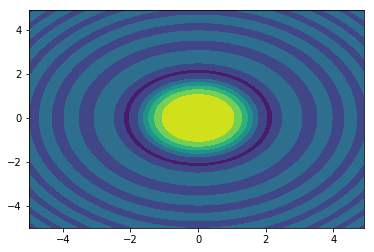

In [17]:
import matplotlib.pyplot as plt
x = np.arange(-5, 5, 0.1)
y = np.arange(-5, 5, 0.1)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
h = plt.contourf(x,y,z)
plt.show()

In [18]:
np.c_[np.array([1,2,3]), np.array([4,5,6])]

array([[1, 4],
       [2, 5],
       [3, 6]])

In [0]:
# visualization functions 2
# two given parameters: given density function U(z) and save path directory
def plot_density(density, directory):
    # set range for the plot
    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)
    
    # numpy.linspace(start, stop, num=50)
    # return evenly spaced numbers over a specified interval
    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    # return coordinate matrices from coordinate vectors
    x1, x2 = np.meshgrid(x1, x2)
    # return (300，300) here
    shape = x1.shape
    # returns contiguous flattened array(1D array with all the input-array elements 
    # and with the same type as it 
    x1 = x1.ravel()
    x2 = x2.ravel()
    
    # translates slice objects to concatenation along the second axis
    z = np.c_[x1, x2]
    # turn z into tensor type and accept Variable() as input
    z = torch.FloatTensor(z)
    z = Variable(z)
    # turn the evenly spaced numbers into transformed ones according to given U(z) distribution function
    # this is the true distribution
    density_values = density(z).data.numpy().reshape(shape)
    
    # save figure to given directory
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.imshow(density_values, extent=(*X_LIMS, *Y_LIMS), cmap="summer")
    ax.set_title("True density")
    fig.savefig(os.path.join(directory, "density.png"))
    plt.close()

#### RUN EXPERIMENT:

In [0]:
# argparse package
# The argparse module makes it easy to write user-friendly command-line interfaces
# The program defines what arguments it requires, and argparse will figure out how to parse those out of sys.argv
# The argparse module also automatically generates help and usage messages and issues 
# errors when users give the program invalid arguments

In [0]:
# ArgementParser objects allow the help formatting to be customized by specifying an alternate formatting clas:
# Three possible class:
# 1. class argparse.RawDescriptionHelpFormatter
# 2. class argparse.RawTextHelpFormatter
# 3. class argparse.ArgumentDefaultsHelpFormatter

# The first two allow more control over how textual descriptions are displayed
# while the last automatically adds information about argument default values.

In [0]:
# parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# parser.add_argument("--log_interval", type=int, default=300, help="How frequenlty to print the training stats.")
# parser.add_argument("--plot_interval", type=int, default=300, help="How frequenlty to plot samples from current distribution.")
# parser.add_argument("--plot_points", type=int, default=1000, help="How many to points to generate for one plot.")
# args = parser.parse_args()

#### Batch Size:
1. The batch size defines the number of samples that will be propagated through the network.
2. For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated through all samples of the network. A problem usually happens with the last set of samples. In our example we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get the final 50 samples and train the network. 

##### Advantages of using a batch size < number of all samples:
1. It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

2. Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

##### Disadvantages of using a batch size < number of all samples:
The smaller the batch the less accurate the estimate of the gradient will be. In the figure below you can see that the direction of the mini-batch gradient (green color) fluctuates much more in comparison to the direction of the full batch gradient (blue color).

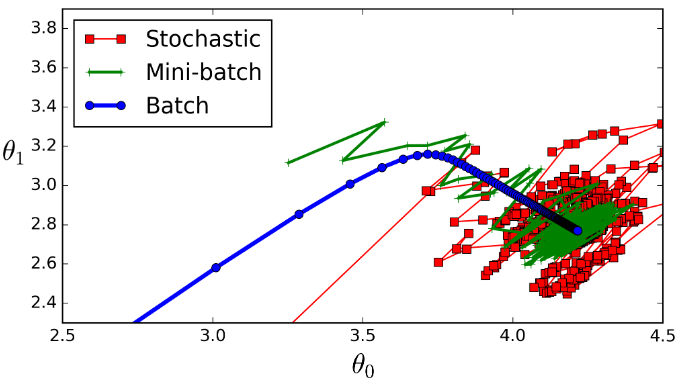

In [0]:
Image(filename='batch.PNG', width=400)

In [21]:
# sets the random seed from pytorch random number generators
torch.manual_seed(42)

# redefine args
# "How frequenlty to print the training stats"
# "How frequenlty to plot samples from current distribution"
# "How many points to generate for one plot"
args = easydict.EasyDict({
        "log_interval": 2000,
        "plot_interval": 2000,
        "plot_points": 1000
})
# two functions to decide print or plot training result after iterations
def should_log(iteration):
    return iteration % args.log_interval == 0
def should_plot(iteration):
    return iteration % args.plot_interval == 0

# parameters for the experiment
# explanation:
# number of sub-groups used to train the network
# number of iterations in optimization method
# initial learning rate
# learning rate decay multiplier
# length of linear transformation
# type of flows
config = easydict.EasyDict({
    "batch_size": 40,
    "iterations": 6000,
    "initial_lr": 0.01,
    "lr_decay": 0.999,
    "flow_length": 8,
    "name": "planar"
})

# set up 2-dimensional data to form normalizing flow class
flow = NormalizingFlow(dim=2, flow_length=config.flow_length)
# using given density function to estimate F(x) bound
bound = FreeEnergyBound(density=p_z)

# Implement the RMSprop algorithm
# params (iterable): iterable of parameters to optimize or dicts defining parameter groups
# lr(float, optional): learning rate (default: 1e-2)

# RMSprop optimizer is similar to the gradient descent algorithm with momentum
# The RMSprop optimizer restricts the oscillations in the vertical direction
# Therefore, we can increase our learning rate and 
# the algorithm could take larger steps in the horizontal direction converging faster
# The difference between RMSprop and gradient descent is on how the gradients are calculated
optimizer = optim.RMSprop(flow.parameters(), lr=config.initial_lr)

# set the learning rate of each parameter group to the initial lr decayed by gamma every epoch
# when last_epoch=-1, set initial lr as lr
# parameter/arg: 
# optimizer (Optimizer): Wrapped optimizer -- method
# gamma (float): Multiplicative factor of learning rate decay
# last_epoch (int): The index of last epoch. Default: -1
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, config.lr_decay)

# An epoch is a single step in training a neural network; 
# when a neural network is trained on every training samples only in one pass we say that one epoch is finished
for iteration in range(1, config.iterations+1):
    # optimizer.step() is often used in mini-batch while scheduler.step() in epoch a lot
    # optimizer.step() updates the model while scheduler.step() updates the learning rate
    scheduler.step()
    # generate given number of random normal samples
    samples = Variable(random_normal_samples(config.batch_size))
    # calculate Zk and Log Jacobians list for the sample
    zk, log_jacobians = flow(samples)
    
    # gradients are not automatically zeroed because these two operations
    # loss.backward() and optimizer.step(), are separated
    # if need to accumulate gradients then call backward multiple times and optimize once
    optimizer.zero_grad()
    loss = bound(zk, log_jacobians)
    # loss.backward() computes dloss/dx for every parameter x
    loss.backward()

    # optimizer.step updates the value of x using the gradient x.grad.
    # e.g Stochastic Gradient Descent:x += -lr * x.grad
    optimizer.step()
    
    if should_log(iteration):
        print("Loss on iteration {}: {}".format(iteration, loss.data))
    if should_plot(iteration):
        # still generate some normal samples from the true distribution
        samples = Variable(random_normal_samples(args.plot_points))
        # transform according to the estimated parameters in normalizing flow
        zk, det_grads = flow(samples)
        scatter_points(zk.data.numpy(), directory="./", iteration=iteration, flow_length=config.flow_length)

Loss on iteration 2000: 1.323437213897705
Loss on iteration 4000: 1.0610214471817017
Loss on iteration 6000: 0.5909389853477478


In [0]:
#the real density plot
plot_density(p_z, "./")

In [25]:
optimizer

RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    initial_lr: 0.01
    lr: 2.471322117015984e-05
    momentum: 0
    weight_decay: 0
)

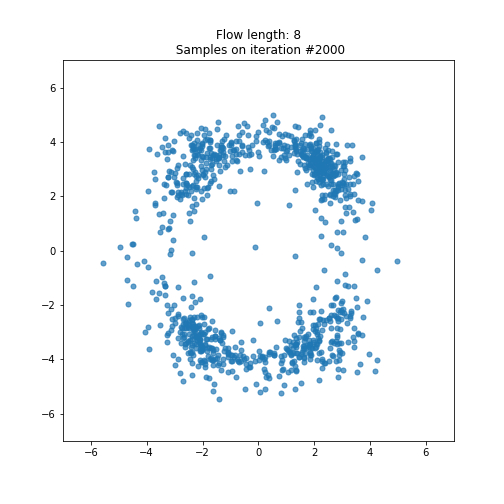

In [28]:
from IPython.display import Image
Image("flow_result_2000.png", width=400)

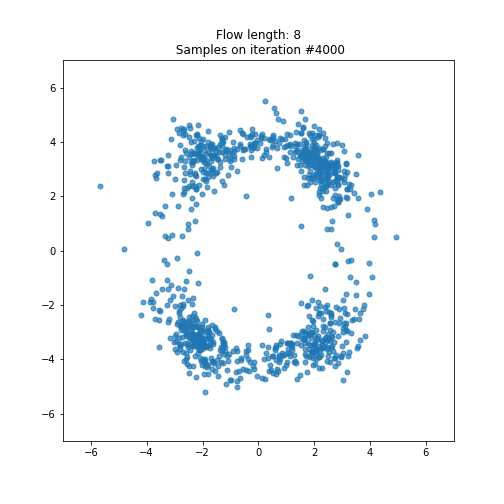

In [29]:
Image("flow_result_4000.png", width=400)

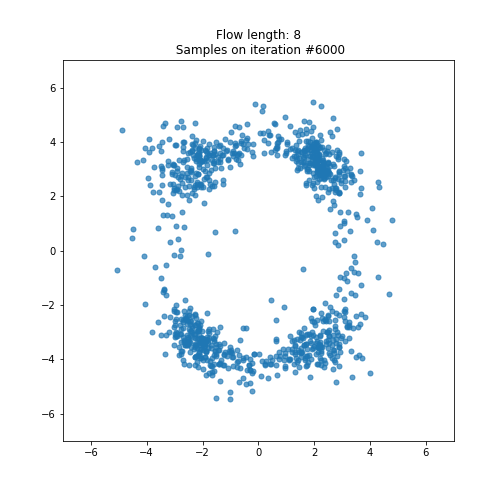

In [30]:
Image("flow_result_6000.png", width=400)